Quick snapshot

Tiles: 71 paired image/label tiles, each 64×64 px. Four input bands per tile.

Classes: 5 classes labeled as integers 1–5 (names are just the numbers in the ESRI metadata).

Per-class coverage (images with that class present):
class 1: 28 images, class 2: 24, class 3: 45, class 4: 36, class 5: 12. Clear class imbalance (class 5 is sparse).

Feature counts (connected regions): total 276 features across the dataset; ~3.9 features/image on average.

Geo/scale hints: tile cell size 0.0002695° in WGS84 (EPSG:4326), which is roughly Landsat-scale (30 m); keep in mind degrees ≠ meters.

map.txt lists 71 one-to-one pairs like images\000000000040.tif ↔ labels\000000000040.tif, so the dataset is properly paired for supervised training.

Band info
ESRI stats say NumBands: 4 for the inputs. That likely means RGB+NIR or a similar 4-band selection; make sure your composite bands at inference match the training band order.

In [20]:
!pip install rasterio

In [21]:
#!pip install earthengine-api geopandas shapely rasterio numpy pandas scikit-learn tensorflow==2.15 tqdm

In [22]:
# ===== 0) Imports & paths =====
from pathlib import Path
import os, json
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

DATA_DIR = Path('/content/drive/MyDrive/AA_training_GEOG')
IMG_DIR = DATA_DIR / 'images'
LBL_DIR = DATA_DIR / 'labels'
MAP_TXT = DATA_DIR / 'map.txt'       # change if your map.txt lives next to the tiles
OUT_MODELS  = DATA_DIR / 'models'
OUT_REPORTS = DATA_DIR / 'reports'
OUT_MODELS.mkdir(parents=True, exist_ok=True)
OUT_REPORTS.mkdir(parents=True, exist_ok=True)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

CLASSES = [0,1,2,3,4,5]  # 0 = background (if present), 1..5 = your classes

In [23]:
# ===== 1) Read map.txt and make pairs =====

def read_pairs(img_dir: Path, lbl_dir: Path, map_txt: Path):
    pairs = []
    with open(map_txt, 'r') as f:
        for line in f:
            s = line.strip()
            if not s or s.startswith('#'):
                continue
            s = s.replace('\\', '/')
            toks = s.split()
            tifs = [Path(t).name for t in toks if t.lower().endswith('.tif')]
            if len(tifs) >= 2:
                img_name, lbl_name = tifs[0], tifs[1]
            elif len(tifs) == 1:
                img_name = lbl_name = tifs[0]
            else:
                continue
            ip = img_dir / img_name
            lp = lbl_dir / lbl_name
            pairs.append((ip, lp))
    return pairs

print(">>>", IMG_DIR, LBL_DIR)
pairs = read_pairs(IMG_DIR, LBL_DIR, MAP_TXT)
print('Pairs:', len(pairs))

>>> /content/drive/MyDrive/AA_training_GEOG/images /content/drive/MyDrive/AA_training_GEOG/labels
Pairs: 71


In [24]:
# ===== 2) Load all tiles into memory =====
def read_img(path: Path):
    with rasterio.open(path) as src:
        arr = src.read()  # (bands,H,W)
    if arr.shape[0] > 4:
        arr = arr[:4]
    return arr.astype(np.float32)

imgs = []
lbls = []
for ip, lp in pairs:
    im = read_img(ip)
    with rasterio.open(lp) as src:
        y = src.read(1).astype(np.int32)
    # Map out-of-range to 0
    # y[(y < 0) | (y > 5)] = 0
    y[(y < 0) | (y > 5) | (y == 255)] = 0
    imgs.append(im)
    lbls.append(y[None, ...])  # add band axis for labels

imgs = np.stack(imgs, 0)        # (N, 4, H, W)
lbls = np.stack(lbls, 0)        # (N, 1, H, W)
print('Images:', imgs.shape, imgs.dtype)
print('Labels:', lbls.shape, lbls.dtype)

Images: (71, 4, 64, 64) float32
Labels: (71, 1, 64, 64) int32


In [25]:

# ===== 3) Simple stats + tile-level class presence =====
N = imgs.shape[0]
H, W = imgs.shape[2], imgs.shape[3]

present = {}
for c in CLASSES:
    present[c] = (lbls == c).any(axis=(1,2,3))  # (N,) True/False

pixel_counts = {c: int((lbls == c).sum()) for c in CLASSES}
print('Pixel counts:', pixel_counts)

Pixel counts: {0: 272750, 1: 480, 2: 542, 3: 7010, 4: 8066, 5: 1968}


In [26]:
# ===== 4) Train/val split (by tiles) =====

idx = np.arange(N)
# Stratify on "dominant class" per tile (argmax of per-tile pixel counts across 1..5)
per_tile_counts = np.stack([ (lbls==c).sum(axis=(1,2,3)) for c in range(1,6) ], axis=1)  # (N,5)
dominant = per_tile_counts.argmax(axis=1)  # 0..4
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=SEED, stratify=dominant)

base_train_X = np.transpose(imgs[train_idx], (0,2,3,1))
mean = base_train_X.mean(axis=(0,1,2), keepdims=False)
std  = base_train_X.std(axis=(0,1,2),  keepdims=False) + 1e-6
scaler = {'mean': mean.tolist(), 'std': std.tolist()}

In [33]:
# 5 Balanced sampler to force positives in every batch ----
has_pos = np.any([(lbls == c).any(axis=(1,2,3)) for c in [1,2,3,4,5]], axis=0)
pos_tiles = train_idx[has_pos[train_idx]]
neg_tiles = train_idx[~has_pos[train_idx]]

# 2 positives : 1 negative
pos_repeat, neg_repeat = 2, 1
balanced_idx = np.concatenate([np.repeat(pos_tiles, pos_repeat),
                               np.repeat(neg_tiles, neg_repeat)])
np.random.shuffle(balanced_idx)

# Use this as your training index (instead of oversampled_idx if you want)
oversampled_idx = balanced_idx


In [28]:
# ===== 6) Build arrays and normalize (train mean/std) =====
X_train = np.transpose(imgs[oversampled_idx], (0,2,3,1))  # (M,H,W,4)
y_train = np.transpose(lbls[oversampled_idx], (0,2,3,1))  # (M,H,W,1)
X_val   = np.transpose(imgs[val_idx], (0,2,3,1))
y_val   = np.transpose(lbls[val_idx], (0,2,3,1))

mean = X_train.mean(axis=(0,1,2), keepdims=True)
std  = X_train.std(axis=(0,1,2), keepdims=True) + 1e-6
X_train = (X_train - mean) / std
X_val   = (X_val   - mean) / std

scaler = {'mean': mean.squeeze().tolist(), 'std': std.squeeze().tolist()}
with open(OUT_MODELS / 'scaler.json', 'w') as f:
    json.dump(scaler, f, indent=2)

In [29]:
# ===== 7) Class weights from train pixels (down-weight background) =====
num_classes = 6  # 0..5
hist = np.bincount(y_train.reshape(-1), minlength=num_classes)
hist = np.where(hist == 0, 1, hist)
inv = hist.max() / hist.astype(np.float32)
class_weights = inv * (len(inv) / inv.sum())
class_weights[0] = 0.0  # ignore background pixels in loss
class_weights = np.clip(class_weights, 0.0, 8.0)


print('Class weights:', class_weights)

Class weights: [0.         2.41947604 2.62735466 0.30914395 0.20200531 0.43512316]


In [30]:
# ===== 8) tf.data with light augmentation =====
BATCH = 16

def aug(x,y):
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_left_right(x); y = tf.image.flip_left_right(y)
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_up_down(x);   y = tf.image.flip_up_down(y)
    k = tf.random.uniform((), 0, 4, dtype=tf.int32)
    x = tf.image.rot90(x, k); y = tf.image.rot90(y, k)
    return x, y


In [31]:
# ===== 9) Model: compact U-Net =====

def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding='same', use_bias=False)(x); x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(f, 3, padding='same', use_bias=False)(x); x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    return x

def encoder(x, fs):
    skips = []
    for f in fs:
        x = conv_block(x, f); skips.append(x); x = layers.MaxPool2D()(x)
    return x, skips

def up(x, s, f):
    x = layers.UpSampling2D(size=2, interpolation='bilinear')(x)
    x = layers.Concatenate()([x, s])
    return conv_block(x, f)
# then in decoder, use up(...) instead of Conv2DTranspose + concat + conv_block


def decoder(x, skips, fs):
    for f, s in zip(fs, reversed(skips)):
        # x = layers.Conv2DTranspose(f, 2, strides=2, padding='same')(x)
        # x = layers.Concatenate()([x, s])
        # x = conv_block(x, f)
        x = up(x, s, f)
    return x

inputs = layers.Input(shape=(H, W, 4))
x, s = encoder(inputs, [32,64,128])
x = conv_block(x, 256)
x = decoder(x, s, [128,64,32])
outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │      1,152 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │      9,216 │ re_lu_14[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ re_lu_15[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │     18,432 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_16[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │     73,728 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_19[0][0] 

 Total params: 1,930,278 (7.36 MB)

 Trainable params: 1,927,462 (7.35 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [32]:
# ===== 10) Weighted loss + metrics =====
class_weights_tf = tf.constant(class_weights, dtype=tf.float32)

def weighted_sce(y_true, y_pred):
    if tf.rank(y_true) == 4:
        y_true = tf.squeeze(y_true, -1)
    y_true = tf.cast(y_true, tf.int32)
    w = tf.gather(class_weights_tf, y_true)                # (B,H,W)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss * w) / (tf.reduce_sum(w) + 1e-8)

In [ ]:
class MeanIoUForeground(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="mean_iou_fg", **kw):
        super().__init__(name=name, **kw)
        self.cm = self.add_weight("cm", shape=(num_classes,num_classes),
                                  initializer="zeros", dtype=tf.float32)
        self.num_classes = num_classes
    def update_state(self, y_true, y_pred, sample_weight=None):
        if tf.rank(y_true)==4: y_true = tf.squeeze(y_true,-1)
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        cm = tf.math.confusion_matrix(tf.reshape(y_true, [-1]),
                                      tf.reshape(y_pred, [-1]),
                                      num_classes=self.num_classes)
        self.cm.assign_add(tf.cast(cm, tf.float32))
    def result(self):
        cm = self.cm
        inter = tf.linalg.diag_part(cm)
        union = tf.reduce_sum(cm,0) + tf.reduce_sum(cm,1) - inter
        iou = inter / tf.maximum(union, 1.0)
        return tf.reduce_mean(iou[1:])  # exclude class 0
    def reset_state(self): self.cm.assign(tf.zeros_like(self.cm))

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=weighted_sce,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc"),
             MeanIoUForeground(num_classes=num_classes)]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(str(OUT_MODELS/'unet_best.keras'),
                                    monitor='val_mean_iou_fg', mode='max',
                                    save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_mean_iou_fg',
                                      mode='max', patience=3, factor=0.5, min_lr=1e-5),
    keras.callbacks.EarlyStopping(monitor='val_mean_iou_fg',
                                  mode='max', patience=8, restore_best_weights=True),
    keras.callbacks.CSVLogger(str(OUT_REPORTS/'training_log.csv'))
]

model.save(OUT_MODELS/'unet_final.keras')


In [34]:
# ===== 11) Train =====
# train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
#             .shuffle(1000, seed=SEED)
#             .batch(BATCH)
#             .map(aug)
#             .map(lambda x, y: (x, tf.cast(y, tf.int32)))
#             .prefetch(tf.data.AUTOTUNE))
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(1000, seed=SEED)
            .map(aug, num_parallel_calls=tf.data.AUTOTUNE)  # <-- move here
            .map(lambda x,y: (x, tf.cast(y, tf.int32)))
            .batch(BATCH)
            .prefetch(tf.data.AUTOTUNE))


val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(BATCH)
          .map(lambda x, y: (x, tf.cast(y, tf.int32)))
          .prefetch(tf.data.AUTOTUNE))

print(">>> start training")
print("Label min/max:", y_train.min(), y_train.max())
history = model.fit(train_ds, validation_data=val_ds, epochs=60, callbacks=callbacks)
model.save(OUT_MODELS / 'unet_final.keras')

>>> start training
Label min/max: 0 5
Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - acc: 0.9341 - loss: nan - mean_iou: 0.1557 - val_acc: 0.9220 - val_loss: nan - val_mean_iou: 0.1537 - learning_rate: 0.0010
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - acc: 0.9369 - loss: nan - mean_iou: 0.1561 - val_acc: 0.9220 - val_loss: nan - val_mean_iou: 0.1537 - learning_rate: 0.0010
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - acc: 0.9298 - loss: nan - mean_iou: 0.1550 - val_acc: 0.9220 - val_loss: nan - val_mean_iou: 0.1537 - learning_rate: 0.0010
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - acc: 0.9268 - loss: nan - mean_iou: 0.1545 - val_acc: 0.9220 - val_loss: nan - val_mean_iou: 0.1537 - learning_rate: 0.0010
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - acc: 0.9281 - loss: nan - mean_iou: 0.1547 - val_acc: 0.9220 - val_loss: nan - val_mean_iou: 0.1537 - learning_rate: 0.0010
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - acc: 0.9217 - loss: nan - mean_iou: 0.1536

In [35]:
# ===== 12) Evaluate on val: confusion matrix + per-class IoU =====
val_preds, val_trues = [], []
for xb, yb in val_ds:
    pb = model.predict(xb, verbose=0)
    val_preds.append(pb.argmax(-1).astype(np.int32))
    val_trues.append(yb.numpy().squeeze(-1).astype(np.int32))

vp = np.concatenate(val_preds, 0).reshape(-1)
vt = np.concatenate(val_trues, 0).reshape(-1)

cm = confusion_matrix(vt, vp, labels=list(range(num_classes)))
np.savetxt(OUT_REPORTS/'confusion_matrix_val.csv', cm, fmt='%d', delimiter=',')

inter = np.diag(cm)
union = cm.sum(0) + cm.sum(1) - inter
per_class_iou = inter / np.maximum(union, 1)
fg_mean_iou = per_class_iou[1:].mean()

with open(OUT_REPORTS/'per_class_iou_val.json','w') as f:
    json.dump({
        'per_class_iou': per_class_iou.tolist(),
        'fg_mean_iou': float(fg_mean_iou)
    }, f, indent=2)

with open(OUT_REPORTS/'data_card.json','w') as f:
    json.dump({
      'tiles': int(N), 'tile_shape': [int(H), int(W)], 'bands': 4,
      'classes': 6, 'boost_classes': dict(BOOST_CLASSES),
      'class_weights': [float(x) for x in class_weights],
      'scaler': {'mean': np.array(scaler['mean']).tolist(),
                 'std':  np.array(scaler['std']).tolist()},
      'seed': SEED
    }, f, indent=2)

print("Foreground mIoU (1–5):", fg_mean_iou)

print('Saved:')
print('  ', OUT_MODELS / 'unet_best.keras')
print('  ', OUT_MODELS / 'unet_final.keras')
print('  ', OUT_REPORTS / 'confusion_matrix_val.csv')
print('  ', OUT_REPORTS / 'per_class_iou_val.json')
print('  ', OUT_REPORTS / 'data_card.json')

Saved:
   /content/drive/MyDrive/AA_training_GEOG/models/unet_best.keras
   /content/drive/MyDrive/AA_training_GEOG/models/unet_final.keras
   /content/drive/MyDrive/AA_training_GEOG/reports/confusion_matrix_val.csv
   /content/drive/MyDrive/AA_training_GEOG/reports/per_class_iou_val.json
   /content/drive/MyDrive/AA_training_GEOG/reports/data_card.json


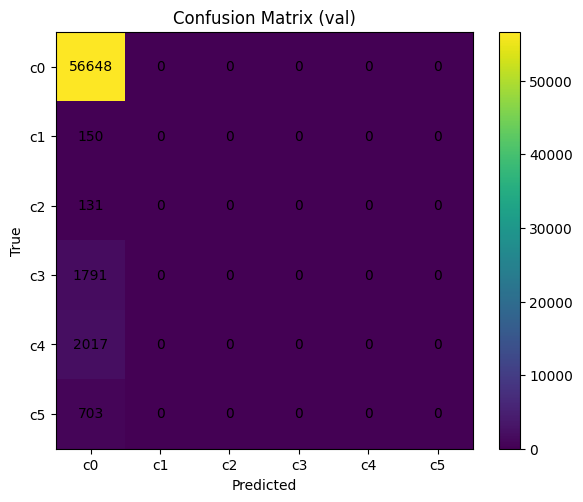

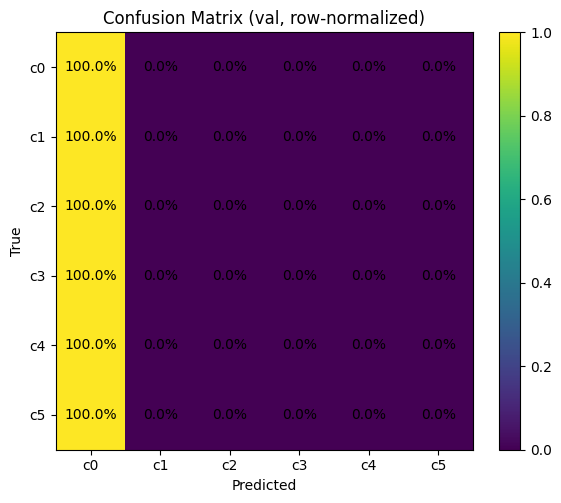

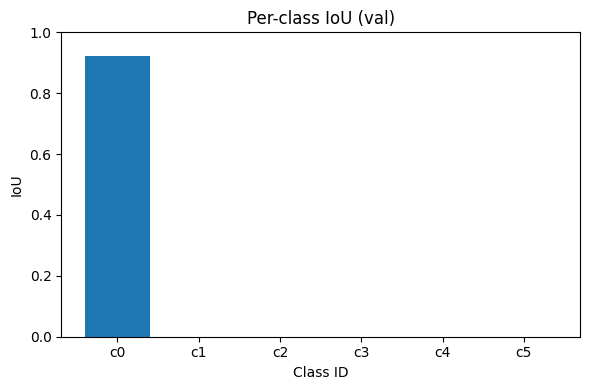

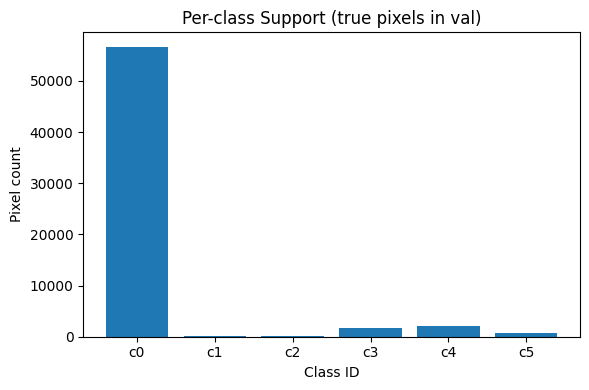

In [36]:
# ===== 13) Visualize performance (confusion matrix + histograms) =====
import numpy as np
import matplotlib.pyplot as plt

class_ids = list(range(num_classes))   # [0..5]
class_names = [f"c{c}" for c in class_ids]  # or replace with actual names if you have them

# --- Confusion Matrix (counts) ---
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Confusion Matrix (val)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks(class_ids); ax.set_yticks(class_ids)
ax.set_xticklabels(class_names, rotation=0)
ax.set_yticklabels(class_names)
fig.colorbar(im, ax=ax)
# annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.show()

# --- Confusion Matrix (row-normalized) ---
cm_norm = cm.astype(np.float32)
row_sums = cm_norm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
cm_norm = cm_norm / row_sums

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_norm, interpolation='nearest')
ax.set_title('Confusion Matrix (val, row-normalized)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks(class_ids); ax.set_yticks(class_ids)
ax.set_xticklabels(class_names, rotation=0)
ax.set_yticklabels(class_names)
fig.colorbar(im, ax=ax)
# annotate percentages
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f"{cm_norm[i, j]*100:.1f}%", ha='center', va='center')
plt.tight_layout()
plt.show()

# --- Per-class IoU bar chart ---
ious_plot = [0.0 if (i is None or np.isnan(i)) else float(i) for i in ious]
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(class_ids, ious_plot)
ax.set_title('Per-class IoU (val)')
ax.set_xlabel('Class ID')
ax.set_ylabel('IoU')
ax.set_xticks(class_ids); ax.set_xticklabels(class_names)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# --- Per-class support (true pixels) ---
support = [(vt == c).sum() for c in class_ids]
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(class_ids, support)
ax.set_title('Per-class Support (true pixels in val)')
ax.set_xlabel('Class ID')
ax.set_ylabel('Pixel count')
ax.set_xticks(class_ids); ax.set_xticklabels(class_names)
plt.tight_layout()
plt.show()
